### Rolling predictions 

Comparing results on scikit tree & forest, prophet, SARIMA and craft on energy time series

We start by feeding the model 2 months of data, and ask them to predict 1 week

In [1]:
import pandas as pd
import numpy as np
import subprocess
import json
import benchmark_tools as bt
import pickle
import os
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

In [2]:
palette = sns.color_palette("Set2", 10, 0.9)
sns.set_palette(palette)
sns.set_style("dark")
import imp
imp.reload(bt)
os.getcwd()

'C:\\Users\\Claire\\Documents\\craft-ai-kit-energy\\benchmark'

In [3]:
import logging
import warnings
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [62]:
week_unit = 7*24*60
week_offset = 50
start_index = week_offset * week_unit
start_pred_index = start_index + 2*52*week_unit
data = pd.read_csv('data/uci/uci_household_power_consumption.csv', parse_dates=['date'])

#Remove the first year to let only the last 3 years for predictions
data = data.iloc[start_index-1:]
# Getting rid of nan values
data.index = pd.to_datetime(data.date)
data = data.dropna().drop('date',1)
print('Cleaned dataset: {:d} rows, {:d} columns'.format(data.shape[0],data.shape[1]))
print('Types of data: \n{}'.format(data.dtypes))

#Adding temperature information
temp = pd.read_json('provider/weather_cache_uci.json', convert_dates=['date'])
temp['date'] = temp.iloc[:,0].str.extract(r'[\d]+\.[\d]+,[\d]+\.[\d]+,([\d]+)')
temp['temperatureLow'] = temp.iloc[:,1].apply(lambda x : x['temperatureLow'])
temp['temperatureHigh'] = temp.iloc[:,1].apply(lambda x : x['temperatureHigh'])
temp.index = pd.to_datetime(temp.date, unit='s')
temp = temp.sort_index()
temp = temp.drop([0,1,'date'],1)

data = data.merge(temp, how='left', left_index=True, right_index=True)

Cleaned dataset: 1549215 rows, 1 columns
Types of data: 
load    float64
dtype: object


In [63]:
data = data.fillna(method='ffill')
data = data[1:] #Adapt to fit with rolling craft preds

In [64]:
data.index.values[0], data.index.values[-1]

(numpy.datetime64('2007-12-01T17:24:00.000000000'),
 numpy.datetime64('2010-11-26T21:02:00.000000000'))

In [65]:
print('{} semaines dans les données'.format(round((data.index[-1] - data.index[0]).days/7,2)))

155.86 semaines dans les données


In [66]:
data.head()

,load,temperatureLow,temperatureHigh
date,,,
2007-12-01 17:24:00,2724.0,7.84,10.56
2007-12-01 17:25:00,2736.0,7.84,10.56
2007-12-01 17:26:00,2746.0,7.84,10.56
2007-12-01 17:27:00,2740.0,7.84,10.56
2007-12-01 17:28:00,2724.0,7.84,10.56


In [67]:
data.tail()

,load,temperatureLow,temperatureHigh
date,,,
2010-11-26 20:58:00,946.0,-0.93,3.14
2010-11-26 20:59:00,944.0,-0.93,3.14
2010-11-26 21:00:00,938.0,-0.93,3.14
2010-11-26 21:01:00,934.0,-0.93,3.14
2010-11-26 21:02:00,932.0,-0.93,3.14


In [25]:
#Retrieve craft predictions 
one = pd.read_json('preds/uci_10_rolling_results_1.json', convert_dates=['date']).set_index('date')
two = pd.read_json('preds/uci_10_rolling_results_2.json', convert_dates=['date']).set_index('date')
three = pd.read_json('preds/uci_10_rolling_results_3.json', convert_dates=['date']).set_index('date')

In [28]:
craft_preds = pd.concat([one,two,three])

In [50]:
week_index =  int(start_pred_index/week_unit) - week_offset# let's start the rolling preds for the last year
max_week_index = int(data.shape[0]/week_unit)

idx = ['scikit tree', 'scikit forest', 'prophet']
scores = []
all_preds = []
# max_week_index
last_train_index = week_index * week_unit
last_test_index = (week_index +1) * week_unit
week_preds = {}

data_train, data_test = bt.split_data(data, last_train_index-1 , last_test_index-1)

#limit to one year of data to avoid memory error
for i in range(1,42,10):
    print('computing prophet with {} weeks in the training data'.format(i))
    %time bt.get_prophet_preds(data_train, data_test, exog = ['temperatureLow', 'temperatureHigh'], max_feed = i*week_unit)

computing prophet with 1 weeks in the training data
Wall time: 42.9 s
computing prophet with 11 weeks in the training data
Wall time: 4min 13s
computing prophet with 21 weeks in the training data
Wall time: 10min 38s
computing prophet with 31 weeks in the training data
Wall time: 12min 42s
computing prophet with 41 weeks in the training data
Wall time: 14min 20s


In [92]:
data.head()

,load,temperatureLow,temperatureHigh
date,,,
2007-12-01 17:24:00,2724.0,7.84,10.56
2007-12-01 17:25:00,2736.0,7.84,10.56
2007-12-01 17:26:00,2746.0,7.84,10.56
2007-12-01 17:27:00,2740.0,7.84,10.56
2007-12-01 17:28:00,2724.0,7.84,10.56


In [93]:
craft_preds.head()

,confidence,context,decisionRules,predictedLoad,standardDeviation
date,,,,,
2009-11-28 17:24:00,0.5,"{'time': 18.4, 'day': 5, 'month': 11, 'timezon...","[{'operand': [7.8, 0.5], 'operator': '[in[', '...",4416.0,0.0
2009-11-28 17:25:00,0.5,"{'time': 18.416666666666668, 'day': 5, 'month'...","[{'operand': [7.8, 0.5], 'operator': '[in[', '...",4416.0,0.0
2009-11-28 17:26:00,0.5,"{'time': 18.433333333333334, 'day': 5, 'month'...","[{'operand': [7.8, 0.5], 'operator': '[in[', '...",4416.0,0.0
2009-11-28 17:27:00,0.5,"{'time': 18.45, 'day': 5, 'month': 11, 'timezo...","[{'operand': [7.8, 0.5], 'operator': '[in[', '...",4416.0,0.0
2009-11-28 17:28:00,0.5,"{'time': 18.466666666666665, 'day': 5, 'month'...","[{'operand': [7.8, 0.5], 'operator': '[in[', '...",4416.0,0.0


scikit  computed
prophet computed
                  mae   mape     rmse        r2  week
ids                                                  
scikit tree    569.28  71.50   825.52  0.257600   104
scikit forest  553.90  67.78   791.49  0.317554   104
prophet        617.97  93.89   802.68  0.298118   104
craft ai       767.13  88.96  1127.41 -0.384654   104
scikit  computed
prophet computed
                  mae   mape     rmse        r2  week
ids                                                  
scikit tree    626.20  70.21   897.75  0.390186   105
scikit forest  598.29  64.19   891.24  0.398999   105
prophet        698.42  85.29   964.84  0.295641   105
craft ai       707.73  74.62  1077.90  0.120895   105
scikit  computed
prophet computed
                  mae   mape     rmse        r2  week
ids                                                  
scikit tree    602.94  71.41   851.22  0.345461   106
scikit forest  612.55  81.07   840.22  0.362273   106
prophet        672.56  93.11   895

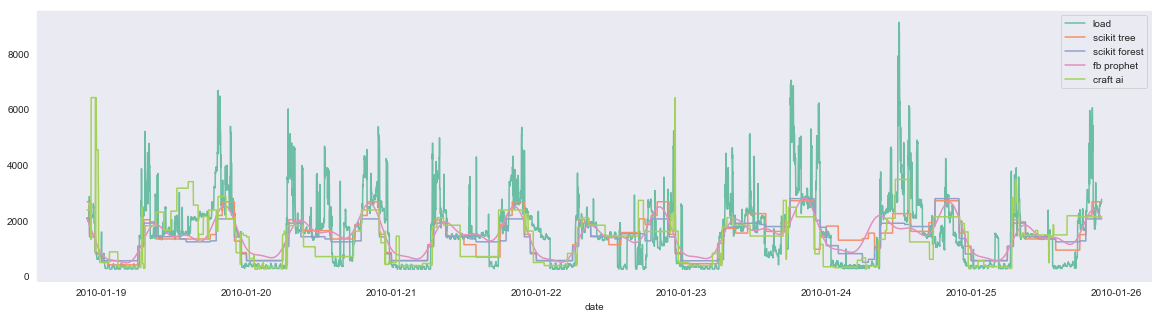

                  mae   mape     rmse        r2  week
ids                                                  
scikit tree    628.77  67.92   936.28  0.381326   111
scikit forest  622.87  62.98   935.08  0.382904   111
prophet        636.05  77.10   933.65  0.384797   111
craft ai       679.75  61.88  1052.74  0.217843   111
scikit  computed
prophet computed
                  mae   mape     rmse        r2  week
ids                                                  
scikit tree    660.81  72.60   968.13  0.286708   112
scikit forest  672.91  77.21   980.84  0.267863   112
prophet        701.53  88.39   987.11  0.258469   112
craft ai       755.16  72.94  1096.06  0.085751   112
scikit  computed
prophet computed
                  mae   mape     rmse        r2  week
ids                                                  
scikit tree    752.89  72.83  1037.26  0.128898   113
scikit forest  666.73  60.88   959.93  0.253936   113
prophet        680.66  81.80   928.56  0.301893   113
craft ai      

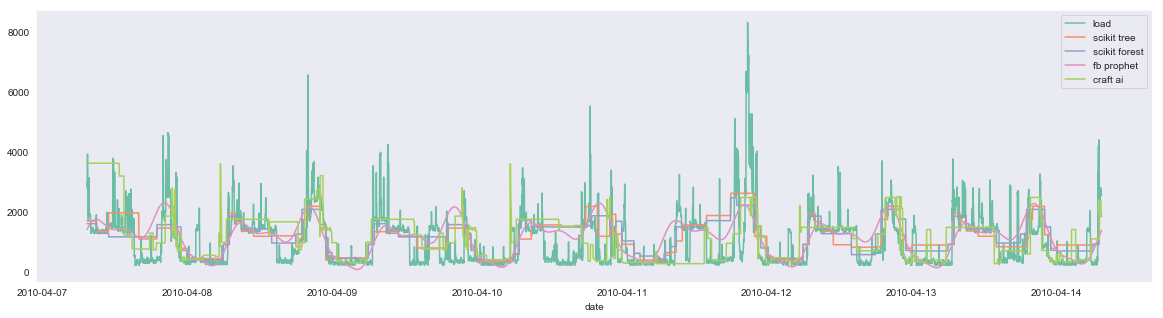

                  mae    mape    rmse        r2  week
ids                                                  
scikit tree    560.09  103.23  770.70  0.234208   122
scikit forest  542.13  100.93  764.81  0.245856   122
prophet        553.69   99.08  786.31  0.202867   122
craft ai       617.45   96.41  898.24 -0.040239   122
scikit  computed
prophet computed
                  mae   mape    rmse        r2  week
ids                                                 
scikit tree    592.00  82.12  827.42  0.107157   123
scikit forest  564.97  83.66  796.35  0.172952   123
prophet        585.41  77.82  801.74  0.161726   123
craft ai       572.61  70.58  832.14  0.096946   123
scikit  computed
prophet computed
                  mae    mape     rmse        r2  week
ids                                                   
scikit tree    667.26  131.56   897.12 -0.451791   124
scikit forest  607.52  115.76   798.91 -0.151344   124
prophet        638.13  117.68   825.92 -0.230508   124
craft ai       

KeyboardInterrupt: 

In [121]:
#Let's start the predictions at the same time with craft :
start_pred = data.index.get_loc(pd.to_datetime('2009-11-28 17:24:00'))

week_index = int(start_pred/week_unit) # let's start the rolling preds for the last year
max_week_index = int(data.shape[0]/week_unit)
first_week_index = week_index
week_unit = 7*24*60

idx = ['scikit tree', 'scikit forest', 'prophet', 'craft ai']
scores = []
all_preds = []
# max_week_index
while week_index < max_week_index :
    last_train_index = start_pred + ( week_index - first_week_index) * week_unit
    last_test_index = last_train_index + week_unit
    week_preds = {}

    data_train, data_test = bt.split_data(data, last_train_index , last_test_index)

    sk_tree_preds = bt.get_scikit_preds(data_train, data_test, 10, exog = ['temperatureLow', 'temperatureHigh'])
    week_preds['scikit tree'] = sk_tree_preds

    forest_preds = bt.get_forest_preds(data_train, data_test, n_estimators=2, max_depth=7, exog = ['temperatureLow', 'temperatureHigh'])
    week_preds['scikit forest'] = forest_preds

    print('scikit  computed')

    #limit to one year of data to avoid memory error
    prophet_preds = bt.get_prophet_preds(data_train, data_test, exog = ['temperatureLow', 'temperatureHigh'], max_feed = 21*week_unit)

    week_preds['fb prophet'] = prophet_preds
    print('prophet computed')
#     try:
#         sarima_preds = bt.get_sarima_preds(data_train, data_test,week_unit, max_feed=3000)
#         week_preds['sarima'] = sarima_preds
#     except MemoryError:
#         print("Memory error for sarima preds on week", week_index)
#         sarima_preds = []
#         continue
    
     #compute craft ai preds 
    
    craft_preds_week = craft_preds.iloc[ (week_index - first_week_index)*week_unit : (week_index - first_week_index +1) * week_unit]
    crp = craft_preds_week['predictedLoad'].values
    week_preds['craft ai'] = crp
    
    #get scores for the current week
    frame = bt.get_models_scores(data_test=data_test,
                      predictions=[sk_tree_preds, forest_preds, prophet_preds, crp], 
                      idx =idx)
    frame['week'] = week_index +1 
    scores.append(frame)
    all_preds.append(week_preds)

    with open('scores_uci_bench.pickle', 'wb') as f:
        # Pickle the score array so that we can retrieve the scores if the prog fails
        pickle.dump(scores, f, pickle.HIGHEST_PROTOCOL)

    with open('preds_uci_dict.pickle', 'wb') as f:
        # Pickle the preds array so that we can plot and compare after 
        pickle.dump(all_preds, f, pickle.HIGHEST_PROTOCOL)

    #once in a while, print our predictions to see how they compare to each other and to the real values
    if (week_index%11 ==0):
        print("Model predictions for week n° {}".format(week_index+1))
        bt.plot_period_predictions(data_test=data_test.drop( ['temperatureLow', 'temperatureHigh'],1),
                                    predictions = week_preds)
    #print scores 
    print(frame)
    #update index
    week_index +=1

### Scores finaux 

In [18]:
final_table = scores[0]
for score in scores[1:]:
    final_table = pd.concat([final_table, score],0)
final_table = final_table.reset_index().set_index(['ids', 'week'])

On two years :

In [19]:
final_table.groupby(by='ids').mean()

,mae,mape,rmse,r2
ids,,,,
6,448.824742,42.088454,689.195876,0.151589
7,412.938144,37.125052,661.206186,0.217005
8,455.896907,42.356186,711.814433,0.085970
9,408.371134,36.357113,659.855670,0.214396
10,477.711340,44.405567,756.164948,-0.052798
11,416.649485,38.396598,669.783505,0.184951


After one year

In [60]:
#Après 1 an :
final_table.iloc[:6*52].groupby(by='ids').mean()

,mae,mape,rmse,r2
ids,,,,
6,472.192308,44.595192,711.038462,0.096146
7,437.076923,39.580385,683.365385,0.162343
8,484.192308,45.280000,742.230769,0.002411
9,444.807692,39.985385,698.903846,0.118546
10,509.596154,47.710962,793.000000,-0.171897
11,387.980769,35.715000,615.846154,0.317252


After one year and a half

In [61]:
#Après 1 an et demi:
final_table.iloc[:6*78].groupby(by='ids').mean()

,mae,mape,rmse,r2
ids,,,,
6,438.679487,41.508205,679.166667,0.129845
7,404.128205,36.735128,651.307692,0.196968
8,446.782051,41.778718,704.794872,0.054068
9,402.448718,36.262821,653.397436,0.187084
10,468.833333,43.789487,749.384615,-0.093431
11,391.487179,36.174103,637.576923,0.212181


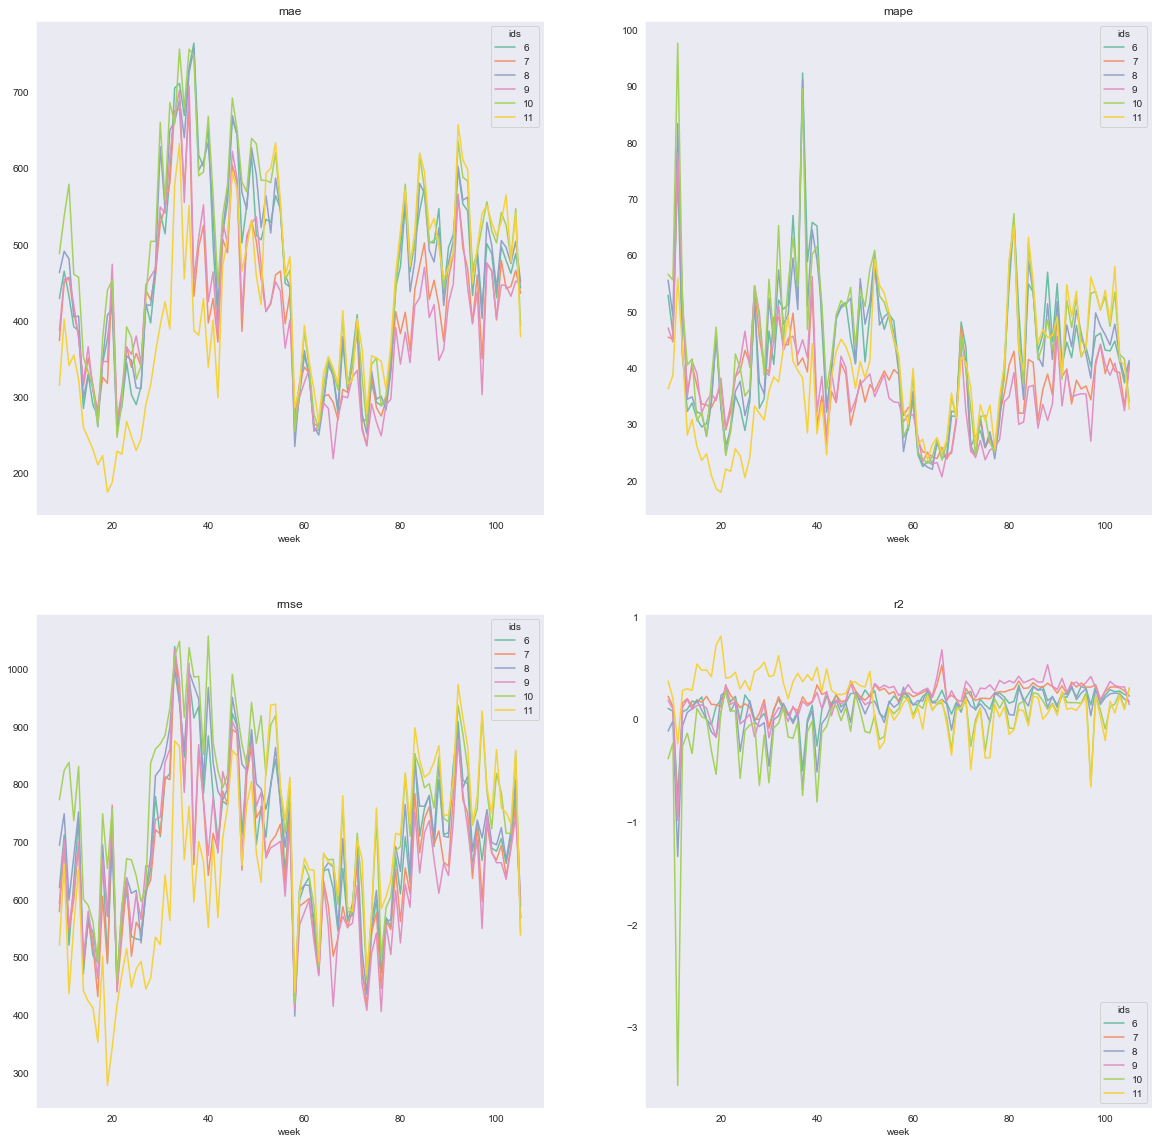

In [55]:
#printing the results 
fig, axes = plt.subplots(2,2, figsize=(20,20))
indexes = list(itertools.product(np.arange(0,2), np.arange(0,2)))
for i,metric in enumerate(final_table.columns):
    final_table.unstack()[metric].T.plot(ax = axes[indexes[i]])
    axes[indexes[i]].set_title(metric)
plt.show()